### **Assignment 2:** Movie Review Sentiment Analysis

IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets.

![alt text](https://www.samyzaf.com/ML/imdb/imdb2.png)

In this assignment we are interested in performing a sentiment analysis on the movie reviews. Your tasks are as following: 

1. **Preprocess** the text and put it in appropriate format (cleaning, tokenization ... as seen in the lab) (20 points)
2. Implement **2 models** of your choice (with lstm's , RNN's ...) One with trainable embedding layer and in the second use embeddings from word2vec or Glov in the embedding layer ( you can use library such as gensim) (20 points)
3. **Compare** the performance of the two models (5 pts)
3. Use **TSNE** or **Umap** to vizualise words and their vectors in the latent space (of the trainable embedding)( 15 points) 
4. **Report** metrics and loss using tensorbord/comet or any tool you are comfortable with.  (5 points) 

Clean and documented code (10 points)             
Correct method (includes correct loss function , parameters tuning, correct training and testing, accuracy value) 25 points.



Remarks : 


*   Use Pytorch
*   Unattached graphs are not counted (0 point)  
*   Cheating will result in a severe penalization
*   Plagiarism is prohibited 




## Reading Data & Preprocessing

In [188]:
from nltk.corpus import stopwords

In [189]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [190]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT1 = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  stop_words = set(stopwords.words('english')),
                  lower = True)
LABEL1 = data.LabelField(dtype = torch.float)

In [191]:
TEXT2 = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  stop_words = set(stopwords.words('english')),
                  lower = True)

LABEL2 = data.LabelField(dtype = torch.float)

## Prepare training and testing data

In [192]:
from torchtext.legacy import datasets

train_data1, test_data1 = datasets.IMDB.splits(TEXT1, LABEL1)

In [193]:
train_data2, test_data2 = datasets.IMDB.splits(TEXT2, LABEL2)

In [194]:
import random

train_data1, valid_data1 = train_data1.split(random_state = random.seed(SEED))

In [195]:
train_data2, valid_data2 = train_data2.split(random_state = random.seed(SEED))

In [196]:
MAX_VOCAB_SIZE = 25_000

TEXT1.build_vocab(train_data1, max_size = MAX_VOCAB_SIZE)
LABEL1.build_vocab(train_data1)

In [197]:
TEXT2.build_vocab(train_data2, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL2.build_vocab(train_data2)

In [198]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator1, valid_iterator1, test_iterator1 = data.BucketIterator.splits(
    (train_data1, valid_data1, test_data1), 
    batch_size = BATCH_SIZE,
    device = device)

In [199]:
train_iterator2, valid_iterator2, test_iterator2 = data.BucketIterator.splits(
    (train_data2, valid_data2, test_data2), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Models

In [200]:
import torch.nn as nn

class RNN1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [201]:
class RNN2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx, embeddings):
        
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze = False, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.dropout(self.embedding(text))

        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
            
        return self.fc(hidden)

In [202]:
INPUT_DIM1 = len(TEXT1.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model1 = RNN1(INPUT_DIM1, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [203]:
pretrained_embeddings = TEXT2.vocab.vectors

INPUT_DIM2 = len(TEXT2.vocab)
EMBEDDING_DIM = pretrained_embeddings.shape[1]
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT2.vocab.stoi[TEXT2.pad_token]

model2 = RNN2(INPUT_DIM2, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX,
            pretrained_embeddings)

## Train & Test



In [205]:
import torch.optim as optim

optimizer1 = optim.SGD(model1.parameters(), lr=1e-3)

In [206]:
optimizer2 = optim.Adam(model2.parameters())

In [207]:
def binary_accuracy(preds, y):

    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [208]:
criterion = nn.BCEWithLogitsLoss()

model1 = model1.to(device)
criterion = criterion.to(device)

In [209]:
model2 = model2.to(device)

In [210]:
def train1(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [211]:
def train2(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [212]:
def evaluate1(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [213]:
def evaluate2(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [214]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [215]:
N_EPOCHS = 5

epoch_tr_loss1,epoch_vl_loss1 = [],[]
epoch_tr_acc1,epoch_vl_acc1 = [],[]

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train1(model1, train_iterator1, optimizer1, criterion)
    valid_loss, valid_acc = evaluate1(model1, valid_iterator1, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    epoch_tr_loss1.append(train_loss)
    epoch_vl_loss1.append(valid_loss)
    epoch_tr_acc1.append(train_acc)
    epoch_vl_acc1.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.694 | Train Acc: 50.46%
	 Val. Loss: 0.696 |  Val. Acc: 49.39%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.693 | Train Acc: 49.76%
	 Val. Loss: 0.697 |  Val. Acc: 48.91%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.693 | Train Acc: 49.87%
	 Val. Loss: 0.696 |  Val. Acc: 49.92%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.693 | Train Acc: 49.79%
	 Val. Loss: 0.697 |  Val. Acc: 48.56%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.693 | Train Acc: 50.01%
	 Val. Loss: 0.696 |  Val. Acc: 50.03%


In [216]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [217]:
epoch_tr_loss2,epoch_vl_loss2 = [],[]
epoch_tr_acc2,epoch_vl_acc2 = [],[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train2(model2, train_iterator2, optimizer2, criterion)
    valid_loss, valid_acc = evaluate2(model2, valid_iterator2, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    epoch_tr_loss2.append(train_loss)
    epoch_vl_loss2.append(valid_loss)
    epoch_tr_acc2.append(train_acc)
    epoch_vl_acc2.append(valid_acc)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/validation", valid_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/validation", valid_acc, epoch)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

writer.flush()

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.637 | Train Acc: 63.08%
	 Val. Loss: 0.524 |  Val. Acc: 75.08%
Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.452 | Train Acc: 79.45%
	 Val. Loss: 0.388 |  Val. Acc: 85.32%
Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 0.328 | Train Acc: 86.64%
	 Val. Loss: 0.287 |  Val. Acc: 87.89%
Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.263 | Train Acc: 89.71%
	 Val. Loss: 0.276 |  Val. Acc: 89.09%
Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.215 | Train Acc: 91.87%
	 Val. Loss: 0.276 |  Val. Acc: 89.10%


In [221]:
test_loss, test_acc = evaluate1(model1, test_iterator1, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.675 | Test Acc: 63.17%


In [222]:
test_loss, test_acc = evaluate2(model2, test_iterator2, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.322 | Test Acc: 86.70%


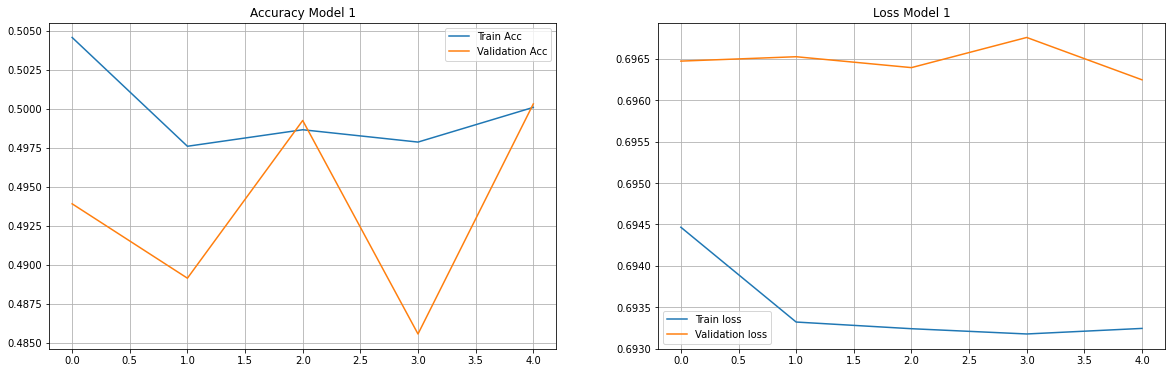

In [223]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc1, label='Train Acc')
plt.plot(epoch_vl_acc1, label='Validation Acc')
plt.title("Accuracy Model 1")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss1, label='Train loss')
plt.plot(epoch_vl_loss1, label='Validation loss')
plt.title("Loss Model 1")
plt.legend()
plt.grid()

plt.show()

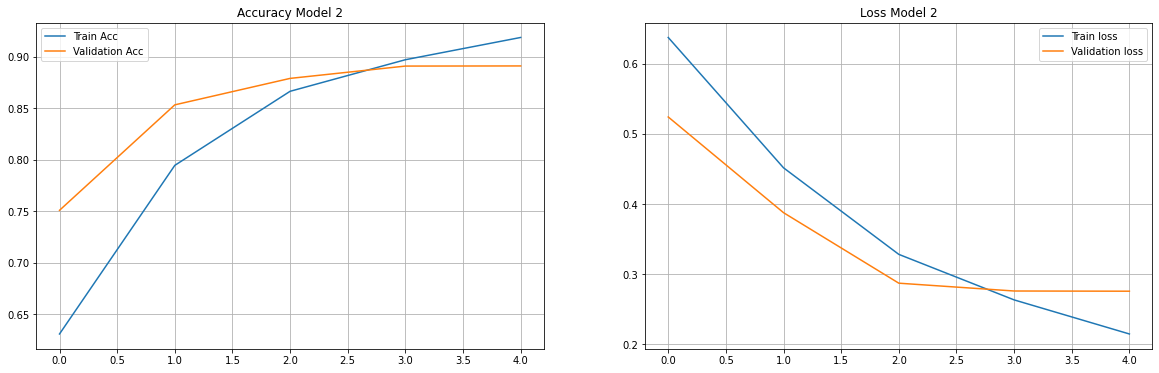

In [224]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc2, label='Train Acc')
plt.plot(epoch_vl_acc2, label='Validation Acc')
plt.title("Accuracy Model 2")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss2, label='Train loss')
plt.plot(epoch_vl_loss2, label='Validation loss')
plt.title("Loss Model 2")
plt.legend()
plt.grid()

plt.show()

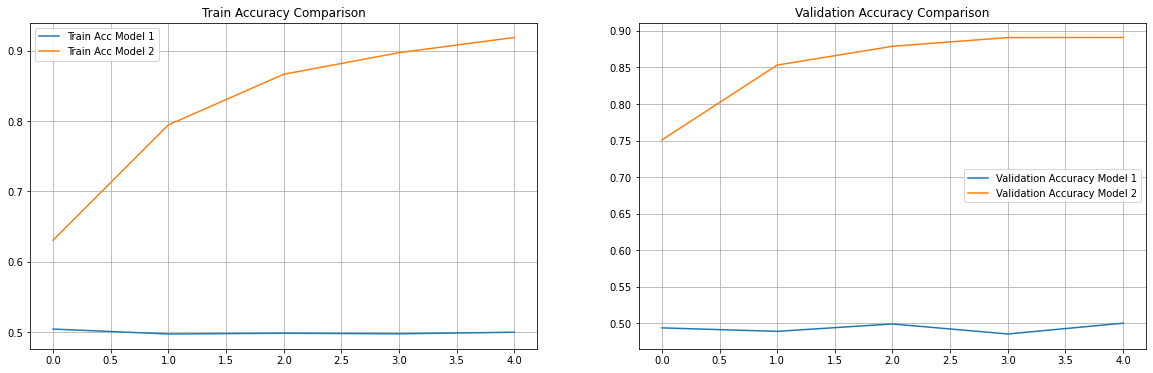

In [225]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc1, label='Train Acc Model 1')
plt.plot(epoch_tr_acc2, label='Train Acc Model 2')
plt.title("Train Accuracy Comparison")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_vl_acc1, label='Validation Accuracy Model 1')
plt.plot(epoch_vl_acc2, label='Validation Accuracy Model 2')
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid()

plt.show()

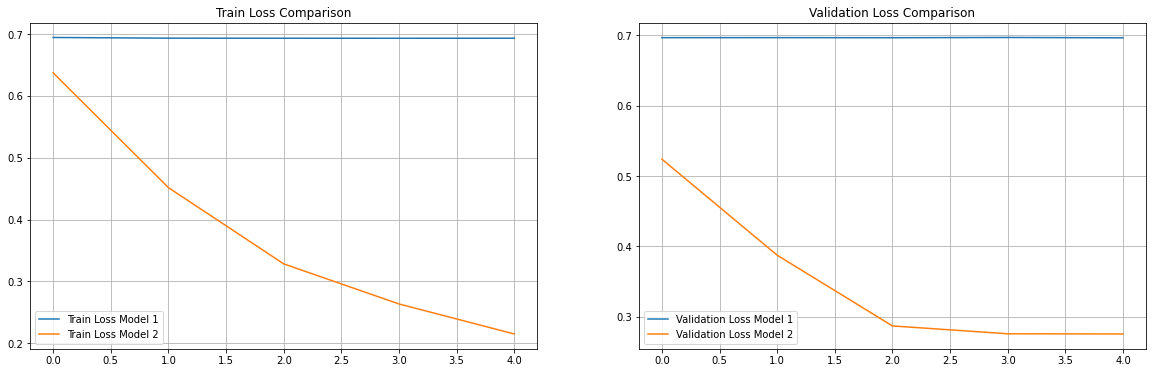

In [226]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_loss1, label='Train Loss Model 1')
plt.plot(epoch_tr_loss2, label='Train Loss Model 2')
plt.title("Train Loss Comparison")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_vl_loss1, label='Validation Loss Model 1')
plt.plot(epoch_vl_loss2, label='Validation Loss Model 2')
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid()

plt.show()

In [227]:
writer.close()

## Vizualisations

In [231]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

In [228]:
w = model2.embedding.weight.data.cpu()

In [230]:
d = TEXT2.vocab.itos

In [232]:
df = pd.DataFrame(d[:5000])

In [235]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
embs = tsne.fit_transform(w[:5000])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.061s...
[t-SNE] Computed neighbors for 5000 samples in 5.396s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.547334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.449425
[t-SNE] KL divergence after 300 iterations: 2.933779
t-SNE done! Time elapsed: 36.554057121276855 seconds


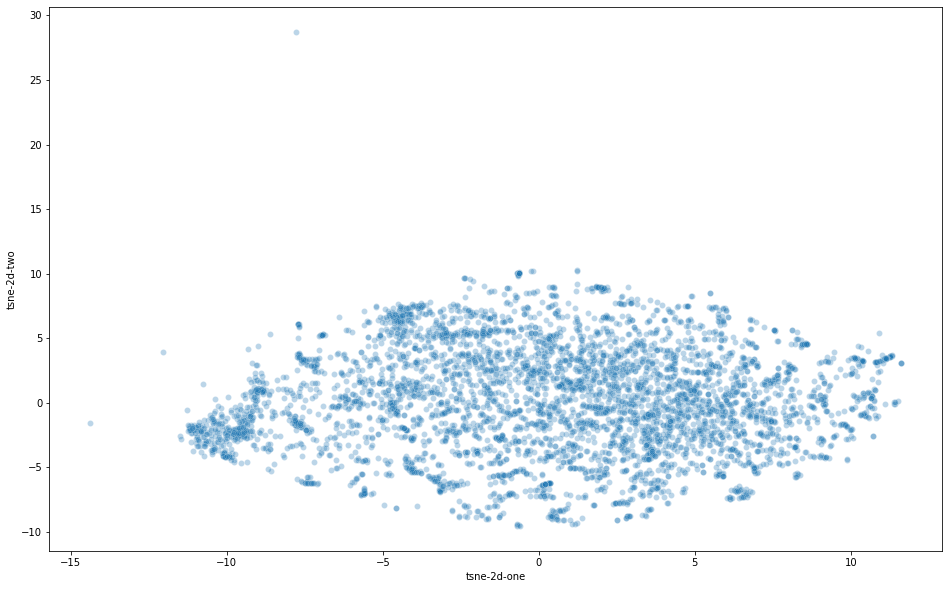

In [236]:
df['tsne-2d-one'] = embs[:,0]
df['tsne-2d-two'] = embs[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # hue="tsne-2d-one",
    palette=sns.color_palette("hls", 1),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
!tensorboard dev upload --logdir runs

https://tensorboard.dev/experiment/D86cqzw0Sw61EqTDVzHDFg/

Reference: https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb